In [ ]:
!pip install wandb==0.16.1





























   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.4 MB/s eta 0:00:00




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.9 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.0/311.0 kB 24.7 MB/s eta 0:00:00



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.6 MB/s eta 0:00:00





In [ ]:
!pip install git+https://github.com/aguirrejuan/ConvRFF.git


  Cloning https://github.com/aguirrejuan/ConvRFF.git to /tmp/pip-req-build-reb6kfh3

  Running command git clone --filter=blob:none --quiet https://github.com/aguirrejuan/ConvRFF.git /tmp/pip-req-build-reb6kfh3

  Resolved https://github.com/aguirrejuan/ConvRFF.git to commit 3eaa190ca53019549dbc20d7f70ce4fa58bcd21d

  Preparing metadata (setup.py) ... done


  Cloning https://github.com/UN-GCPDS/tf-keras-vis.git to /tmp/pip-install-_wiyp9w9/tf-keras-vis_1baf7f7aa39040f7b1cc2c0cf8a079b5

  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/tf-keras-vis.git /tmp/pip-install-_wiyp9w9/tf-keras-vis_1baf7f7aa39040f7b1cc2c0cf8a079b5

  Resolved https://github.com/UN-GCPDS/tf-keras-vis.git to commit 287ad22ee18bef937caee8ad9f793318c96567b0

  Preparing metadata (setup.py) ... done


  Cloning https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git to /tmp/pip-install-_wiyp9w9/gcpds-image-segmentation_b6fadc0d67464f85b8faab600510c64a

  Running command git

In [ ]:
!pip install tensorflow keras

In [ ]:
!pip install numpy pillow scikit-learn

In [ ]:
"""
Importación de la clase Roboflow del paquete roboflow.
Esta biblioteca se utiliza para interactuar con la plataforma Roboflow, permitiendo
descargar y administrar datasets para tareas de visión por computadora.
"""

'\nImportación de la clase Roboflow del paquete roboflow.\nEsta biblioteca se utiliza para interactuar con la plataforma Roboflow, permitiendo\ndescargar y administrar datasets para tareas de visión por computadora.\n'

In [ ]:
!pip install gdown==4.3.0

In [ ]:
!python --version

Python 3.10.12


In [ ]:
"""
https://github.com/cralji/RFF-Nerve-UTP/blob/main/UNET-Nerve-UTP.ipynb
"""
"""función que construye un modelo de U-Net modificado para incluir bloques de
Random Fourier Features (RFF), adecuado para tareas de procesamiento de imágenes
como la segmentación semántica.
"""
from functools import partial
import tensorflow as tf
from tensorflow.keras import Model, layers, regularizers
#from convRFF.layers.convRFF import ConvRFF_block
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

# convRFF

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

def _get_random_features_initializer(initializer, shape, seed):
    def _get_cauchy_samples(loc, scale, shape):
        np.random.seed(seed)
        probs = np.random.uniform(low=0., high=1., size=shape)
        return loc + scale * np.tan(np.pi * (probs - 0.5))

    if isinstance(initializer, str):
        if initializer == "gaussian":
            return tf.keras.initializers.RandomNormal(stddev=1.0, seed=seed)
        elif initializer == "laplacian":
            return tf.keras.initializers.Constant(
                _get_cauchy_samples(loc=0.0, scale=1.0, shape=shape))
        else:
            raise ValueError(f'Unsupported kernel initializer {initializer}')

class ConvRFF(tf.keras.layers.Layer):

    def __init__(self, output_dim, kernel_size=3,
                 scale=None,
                 trainable_scale=False, trainable_W=False,
                 kernel='gaussian',
                 padding='VALID',
                 stride=1,
                 kernel_regularizer=None,
                 normalization=True,
                 seed=None,
                 mass=False,
                 **kwargs):

        super(ConvRFF, self).__init__(**kwargs)

        self.output_dim = output_dim
        self.kernel_size = kernel_size
        self.scale = scale
        self.trainable_scale = trainable_scale
        self.trainable_W = trainable_W
        self.padding = padding
        self.stride = stride
        self.initializer = kernel
        self.kernel_regularizer = kernel_regularizer
        self.normalization = normalization
        self.seed = seed
        self.mass = mass

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'output_dim': self.output_dim,
            'kernel_size': self.kernel_size,
            'scale': self.scale,
            'trainable_scale': self.trainable_scale,
            'trainable_W': self.trainable_W,
            'padding': self.padding,
            'kernel': self.initializer,
            'normalization': self.normalization,
            'seed': self.seed,
            'mass': self.mass
        })
        return config

    def build(self, input_shape):
        input_dim = input_shape[-1]
        kernel_initializer = _get_random_features_initializer(self.initializer,
                                                              shape=(self.kernel_size,
                                                                     self.kernel_size,
                                                                     input_dim,
                                                                     self.output_dim),
                                                               seed=self.seed)

        self.kernel = self.add_weight(
            name='kernel',
            shape=(self.kernel_size, self.kernel_size,
                   input_dim, self.output_dim),
            dtype=tf.float32,
            initializer=kernel_initializer,
            trainable=self.trainable_W,
            regularizer=self.kernel_regularizer,
        )
        self.bias = self.add_weight(
            name='bias',
            shape=(self.output_dim,),
            dtype=tf.float32,
            initializer=tf.keras.initializers.RandomUniform(
                minval=0.0, maxval=2*np.pi, seed=self.seed),
            trainable=self.trainable_W
        )

        if not self.scale:
            if self.initializer == 'gaussian':
                self.scale = np.sqrt((input_dim * self.kernel_size ** 2) / 2.0)
            elif self.initializer == 'laplacian':
                self.scale = 1.0
            else:
                raise ValueError(f'Unsupported kernel initializer {self.initializer}')

        # Verificar si self.scale es un número, no una cadena
        if isinstance(self.scale, str):
           raise ValueError(f"self.scale debe ser numérico, pero se recibió: {self.scale}")
        #print(f"Valor de self.scale: {self.scale}")  # Depuración

        self.kernel_scale = self.add_weight(
            name='kernel_scale',
            shape=(1,),
            dtype=tf.float32,
            initializer=tf.keras.initializers.Constant(self.scale),
            trainable=self.trainable_scale,
            constraint=tf.keras.constraints.NonNeg()
        )

    def _compute_normal_probability(self, x, mean, std):
        constant = 1 / (tf.math.sqrt(2 * np.pi) * std)
        return constant * tf.math.exp(-0.5 * (x - mean) * (x - mean) / (std * std))

    def _compute_mass(self):
        weights = tf.reshape(self.kernel, shape=(-1, self.output_dim))
        ww = tf.linalg.norm(weights, axis=0)
        ww_pos = tf.sort(ww)
        mean_pos = tf.reduce_mean(ww_pos)
        std_pos = tf.math.reduce_std(ww_pos)
        mass_pos = self._compute_normal_probability(ww_pos, mean_pos, std_pos)
        mass_pos = tf.sqrt(tfp.math.trapz(tf.abs(mass_pos), ww_pos))
        return mass_pos

    def call(self, inputs):
        # Verificar el tipo de todas las variables antes de operar
        #print(f"Tipo de inputs: {type(inputs)}")
        #print(f"Forma de inputs: {inputs.shape}")
        #print(f"Tipo de self.kernel: {type(self.kernel)}")
        #print(f"Tipo de self.kernel_scale: {type(self.kernel_scale)}")
        #print(f"Valor de self.kernel_scale: {self.kernel_scale}")

        # Conversión explícita a float32
        self.kernel_scale = tf.cast(self.kernel_scale, tf.float32)

        # Verificar si alguna de las variables críticas es una cadena
        if isinstance(self.kernel_scale, str):
            raise ValueError(f"self.kernel_scale no debería ser una cadena, pero se recibió: {self.kernel_scale}")
        if isinstance(self.kernel, str):
            raise ValueError(f"self.kernel no debería ser una cadena, pero se recibió: {self.kernel}")
        if isinstance(inputs, str):
            raise ValueError(f"inputs no debería ser una cadena, pero se recibió: {inputs}")

        # Verificación antes de la convolución
        #print(f"Forma de self.kernel antes de la multiplicación: {self.kernel.shape}")
        #print(f"Tipo de kernel antes de la multiplicación: {type(self.kernel)}")

        # Realizar la operación de escalado y convolución
        scale = tf.math.divide(1.0, self.kernel_scale)
        #print(f"Tipo de scale después de la división: {type(scale)}")
        #print(f"Valor de scale después de la división: {scale}")

        kernel = tf.math.multiply(scale, self.kernel)
        #print(f"Tipo de kernel después de la multiplicación: {type(kernel)}")
        #print(f"Forma de kernel después de la multiplicación: {kernel.shape}")

        # Aplicar la convolución
        outputs = tf.nn.conv2d(inputs, kernel,
                              strides=[1, self.stride, self.stride, 1],
                              padding=self.padding)
        #print(f"Forma de outputs después de conv2d: {outputs.shape}")

        # Agregar el bias
        outputs = tf.nn.bias_add(outputs, self.bias)
        #print(f"Forma de outputs después de bias_add: {outputs.shape}")

        output_dim = tf.cast(self.output_dim, tf.float32)

        if self.normalization:
            outputs = tf.math.multiply(tf.math.sqrt(2 / output_dim), tf.cos(outputs))
        else:
            outputs = tf.cos(outputs)

        #print(f"Forma de outputs después de cos o normalización: {outputs.shape}")

        outputs = tf.math.multiply(self._compute_mass(), outputs) if self.mass else outputs
        return outputs

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2], self.output_dim)

def ConvRFF_block(x, deepth, mul_dim=3, name='01', trainable_W=True,
                  kernel_size=3, kernel_regularizer=None):

    phi_units = np.round(deepth * mul_dim).astype(np.uint32)
    x = ConvRFF(output_dim=phi_units, kernel_size=kernel_size,
                padding="SAME", trainable_scale=False,
                trainable_W=trainable_W, name=f'ConvRFF_{name}',
                mass=True,
                kernel_regularizer=kernel_regularizer)(x)
    return x


# CODE

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="mCsd7vfhObbMfPrJfrHq")
project = rf.workspace("mamitas").project("thermal-feet")
version = project.version(2)
dataset = version.download("png-mask-semantic")






























   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 7.0 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.9 MB/s eta 0:00:00




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.8 MB/s eta 0:00:00


  Attempting uninstall: idna

    Found existing installation: idna 3.10

    Uninstalling idna-3.10:

      Successfully uninstalled idna-3.10


loading Roboflow workspace...

loading Roboflow project...




Extracting Dataset Version Zip to Thermal-Feet-2 in png-mask-semantic:: 100%|██████████| 384/384 [00:00<00:00, 2533.83it/s]


In [ ]:
#!ls /content/Thermal-Feet-2/test

In [ ]:
#!ls /content/Thermal-Feet-2/train

In [ ]:
#!ls /content/Thermal-Feet-2/valid

In [ ]:
import os
import shutil

def organizar_imagenes_por_extension(ruta_conjunto, conjunto):
    # Rutas de las carpetas de imágenes y las carpetas de destino X_train/X_valid y y_train/y_valid
    carpeta_imagenes = ruta_conjunto  # No necesitamos concatenar el nombre del conjunto aquí
    carpeta_X = os.path.join(ruta_conjunto, f'X_{conjunto}')
    carpeta_y = os.path.join(ruta_conjunto, f'y_{conjunto}')

    # Crear las carpetas de destino
    os.makedirs(carpeta_X, exist_ok=True)
    os.makedirs(carpeta_y, exist_ok=True)

    # Recorrer todas las imágenes en la carpeta de imágenes de entrenamiento o validación
    for filename in os.listdir(carpeta_imagenes):
        # Ruta completa de la imagen
        ruta_imagen = os.path.join(carpeta_imagenes, filename)

        # Verificar si es una imagen jpg
        if filename.endswith(".jpg"):
            # Copiar la imagen jpg a la carpeta X_train/X_valid/X_test
            shutil.move(ruta_imagen, carpeta_X)

        # Verificar si es una imagen png (máscara)
        elif filename.endswith(".png"):
            # Copiar la imagen png a la carpeta y_train/y_valid/y_test
            shutil.move(ruta_imagen, carpeta_y)

def imprimir_contenido_carpetas(ruta):
    print(f"Contenido de la carpeta: {ruta}")
    for root, dirs, files in os.walk(ruta):
        nivel = root.replace(ruta, '').count(os.sep)
        indentacion = ' ' * 4 * nivel
        print('{}{}/'.format(indentacion, os.path.basename(root)))
        subindent = ' ' * 4 * (nivel + 1)
        for file in files:
            if file.endswith(".jpg"):
                print('{}{}'.format(subindent, file))
        for file in files:
            if file.endswith(".png"):
                print('{}{}'.format(subindent, file))

# Rutas para cada conjunto de datos
rutas_conjuntos = [("/content/Thermal-Feet-2/test", "test"),
                   ("/content/Thermal-Feet-2/train", "train"),
                   ("/content/Thermal-Feet-2/valid", "valid")]

# Organizar imágenes para cada conjunto de datos
for ruta_conjunto, conjunto in rutas_conjuntos:
    organizar_imagenes_por_extension(ruta_conjunto, conjunto)

def imprimir_contenido_carpetas(ruta):
    print(f"Contenido de la carpeta: {ruta}")
    for root, dirs, files in os.walk(ruta):
        for name in files:
            print(os.path.join(root, name))
        for name in dirs:
            print(os.path.join(root, name))

# Imprimir contenido de las carpetas
carpetas = ["/content/Thermal-Feet-2/test/X_test", "/content/Thermal-Feet-2/test/y_test",
            "/content/Thermal-Feet-2/train/X_train", "/content/Thermal-Feet-2/train/y_train",
            "/content/Thermal-Feet-2/valid/X_valid", "/content/Thermal-Feet-2/valid/y_valid"]

#for carpeta in carpetas:
#    imprimir_contenido_carpetas(carpeta)

In [ ]:
#list(os.walk('/content/Thermal-Feet-2/test/X_test'))

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Tamaño de lote y dimensiones de las imágenes
batch_size = 32
img_height = 256
img_width = 256

# Función para cargar y convertir las imágenes en RGB
def cargar_imagenes_rgb(ruta):
    imagenes = []
    for filename in os.listdir(ruta):
        if filename.endswith(".jpg"):
            # Cargar imagen RGB
            img = load_img(os.path.join(ruta, filename), target_size=(img_height, img_width))
            img_array = img_to_array(img)
            imagenes.append(img_array)
    return tf.convert_to_tensor(np.array(imagenes))

# Función para cargar y convertir las imágenes de máscara en escala de grises
def cargar_mascaras(ruta):
    imagenes = []
    for filename in os.listdir(ruta):
        if filename.endswith(".png"):
            # Cargar imagen en escala de grises
            img = load_img(os.path.join(ruta, filename), color_mode="grayscale", target_size=(img_height, img_width))
            img_array = img_to_array(img)
            imagenes.append(img_array)
    return tf.convert_to_tensor(np.array(imagenes))

# Directorios de las carpetas de imágenes y máscaras
directorios = ["/content/Thermal-Feet-2/test/X_test", "/content/Thermal-Feet-2/test/y_test",
               "/content/Thermal-Feet-2/train/X_train", "/content/Thermal-Feet-2/train/y_train",
               "/content/Thermal-Feet-2/valid/X_valid", "/content/Thermal-Feet-2/valid/y_valid"]

# Obtener tensores de imágenes RGB
tensores_rgb = [cargar_imagenes_rgb(directorio) for directorio in ["/content/Thermal-Feet-2/test/X_test", "/content/Thermal-Feet-2/train/X_train", "/content/Thermal-Feet-2/valid/X_valid" ]]

# Obtener tensores de máscaras
tensores_mascaras = [cargar_mascaras(directorio) for directorio in ["/content/Thermal-Feet-2/test/y_test", "/content/Thermal-Feet-2/train/y_train", "/content/Thermal-Feet-2/valid/y_valid"]]

# Imprimir las formas de los tensores de imágenes RGB
for i, tensor in enumerate(tensores_rgb):
    print(f"Tensor de imágenes RGB {i+1}: {tensor.shape}")

# Imprimir las formas de los tensores de máscaras
for i, tensor in enumerate(tensores_mascaras):
    print(f"Tensor de máscaras {i+1}: {tensor.shape}")


Tensor de imágenes RGB 1: (18, 256, 256, 3)

Tensor de imágenes RGB 2: (132, 256, 256, 3)

Tensor de imágenes RGB 3: (38, 256, 256, 3)

Tensor de máscaras 1: (18, 256, 256, 1)

Tensor de máscaras 2: (132, 256, 256, 1)

Tensor de máscaras 3: (38, 256, 256, 1)


In [ ]:
X_test, X_train, X_valid = tensores_rgb
y_test, y_train, y_valid = tensores_mascaras

In [ ]:
# Configuración de parámetros por defecto para las capas convolucionales, pooling y upsampling

DefaultConv2D = partial(layers.Conv2D,
                        kernel_size=3, activation='relu', padding="same")

DefaultPooling = partial(layers.MaxPool2D,
                        pool_size=2)

upsample = partial(layers.UpSampling2D, (2,2))

def kernel_initializer(seed):
    """
    Genera un inicializador de kernel basado en la distribución uniforme de Glorot (Xavier).

    Args:
    seed (int): Semilla para la generación de números aleatorios, asegura la reproducibilidad.

    Returns:
    tf.keras.initializers.Initializer: Inicializador de GlorotUniform con la semilla especificada.
    """
    return tf.keras.initializers.GlorotUniform(seed=seed)


def get_model(input_shape=(128,128,3), name='UNET_RFF', out_channels=1,
                kernel_regularizer=None,
                 **kwargs_convRFF):
    """
    Construye un modelo U-Net modificado con bloques de Random Fourier Features (RFF).

    Args:
    input_shape (tuple): Dimensiones de la imagen de entrada (alto, ancho, canales).
    name (str): Nombre del modelo.
    out_channels (int): Número de canales de salida, típicamente 1 para máscaras de segmentación.
    kernel_regularizer (tf.keras.regularizers.Regularizer): Regularizador para las capas convolucionales.
    **kwargs_convRFF (dict): Argumentos adicionales para los bloques ConvRFF.

    Returns:
    tf.keras.Model: Modelo de U-Net con bloques RFF configurado y listo para ser compilado y entrenado.
    """

    # Encoder: Construcción de la parte de codificación del modelo U-Net.

    k_r = kernel_regularizer # Regularizers.L1L2(l1=1e-5, l2=1e-4)

    input_ = layers.Input(shape=input_shape)
    x =  layers.BatchNormalization(name='Batch00')(input_)

    # Primer bloque de convolución y pooling en el encoder

    x =  DefaultConv2D(8,kernel_initializer=kernel_initializer(34),kernel_regularizer=k_r,name='Conv10')(x)
    x =  layers.BatchNormalization(name='Batch10')(x)
    x = level_1 = DefaultConv2D(8,kernel_initializer=kernel_initializer(4),kernel_regularizer=k_r,name='Conv11')(x)
    x =  layers.BatchNormalization(name='Batch11')(x)
    x = DefaultPooling(name='Pool10')(x) # 128x128 -> 64x64

    # Aplicación de un bloque RFF al primer nivel de características

    level_1 =  ConvRFF_block(level_1,deepth=8,name='01',kernel_regularizer=kernel_regularizer,**kwargs_convRFF)

    # Repetición de bloques de convolución, BatchNormalization, y pooling, con incorporación de bloques RFF

    x =  DefaultConv2D(16,kernel_initializer=kernel_initializer(56),kernel_regularizer=k_r,name='Conv20')(x)
    x =  layers.BatchNormalization(name='Batch20')(x)
    x = level_2 = DefaultConv2D(16,kernel_initializer=kernel_initializer(32),kernel_regularizer=k_r,name='Conv21')(x)
    x =  layers.BatchNormalization(name='Batch22')(x)
    x = DefaultPooling(name='Pool20')(x) # 64x64 -> 32x32

    level_2 = ConvRFF_block(level_2,deepth=16,kernel_regularizer=kernel_regularizer, name='02',**kwargs_convRFF)

    x =  DefaultConv2D(32,kernel_initializer=kernel_initializer(87),kernel_regularizer=k_r,name='Conv30')(x)
    x =  layers.BatchNormalization(name='Batch30')(x)
    x = level_3 = DefaultConv2D(32,kernel_initializer=kernel_initializer(30),kernel_regularizer=k_r,name='Conv31')(x)
    x =  layers.BatchNormalization(name='Batch31')(x)
    x = DefaultPooling(name='Pool30')(x) # 32x32 -> 16x16

    level_3 = ConvRFF_block(level_3,deepth=32,kernel_regularizer=kernel_regularizer, name='03',**kwargs_convRFF)

    x = DefaultConv2D(64,kernel_initializer=kernel_initializer(79),kernel_regularizer=k_r,name='Conv40')(x)
    x =  layers.BatchNormalization(name='Batch40')(x)
    x = level_4 =  DefaultConv2D(64,kernel_initializer=kernel_initializer(81),kernel_regularizer=k_r,name='Conv41')(x)
    x =  layers.BatchNormalization(name='Batch41')(x)
    x =  DefaultPooling(name='Pool40')(x) # 16x16 -> 8x8

    level_4 = ConvRFF_block(level_4,deepth=64,kernel_regularizer=kernel_regularizer,name='04',**kwargs_convRFF)

    # Decoder: Construcción de la parte de decodificación del modelo U-Net, utilizando operaciones de upsampling
    # y concatenación para reintroducir características de los niveles anteriores y mejorar la resolución de las predicciones.

    x = DefaultConv2D(128,kernel_initializer=kernel_initializer(89),kernel_regularizer=k_r,name='Conv50')(x)
    x =  layers.BatchNormalization(name='Batch50')(x)
    x = DefaultConv2D(128,kernel_initializer=kernel_initializer(42),kernel_regularizer=k_r,name='Conv51')(x)
    x =  layers.BatchNormalization(name='Batch51')(x)

    x = upsample(name='Up60')(x) # 8x8 -> 16x16
    x = layers.Concatenate()([level_4,x])
    x = DefaultConv2D(64,kernel_initializer=kernel_initializer(91),kernel_regularizer=k_r,name='Conv60')(x)
    x =  layers.BatchNormalization(name='Batch60')(x)
    x = DefaultConv2D(64,kernel_initializer=kernel_initializer(47),kernel_regularizer=k_r,name='Conv61')(x)
    x =  layers.BatchNormalization(name='Batch61')(x)

    x = upsample(name='Up70')(x) # 16x16 -> 32x32
    x = layers.Concatenate()([level_3,x])
    x = DefaultConv2D(32,kernel_initializer=kernel_initializer(21),kernel_regularizer=k_r,name='Conv70')(x)
    x =  layers.BatchNormalization(name='Batch70')(x)
    x = DefaultConv2D(32,kernel_initializer=kernel_initializer(96),kernel_regularizer=k_r,name='Conv71')(x)
    x =  layers.BatchNormalization(name='Batch71')(x)

    x = upsample(name='Up80')(x) # 32x32 -> 64x64
    x = layers.Concatenate()([level_2,x])
    x = DefaultConv2D(16,kernel_initializer=kernel_initializer(96),kernel_regularizer=k_r,name='Conv80')(x)
    x =  layers.BatchNormalization(name='Batch80')(x)
    x = DefaultConv2D(16,kernel_initializer=kernel_initializer(98),kernel_regularizer=k_r,name='Conv81')(x)
    x =  layers.BatchNormalization(name='Batch81')(x)

    x = upsample(name='Up90')(x) # 64x64 -> 128x128
    x = layers.Concatenate()([level_1,x])
    x = DefaultConv2D(8,kernel_initializer=kernel_initializer(35),kernel_regularizer=k_r,name='Conv90')(x)
    x =  layers.BatchNormalization(name='Batch90')(x)
    x = DefaultConv2D(8,kernel_initializer=kernel_initializer(7),kernel_regularizer=k_r,name='Conv91')(x)
    x =  layers.BatchNormalization(name='Batch91')(x)

    # Salida final del modelo

    x = DefaultConv2D(out_channels,kernel_size=(1,1),activation='sigmoid',
                        kernel_initializer=kernel_initializer(42),kernel_regularizer=k_r,
                        name='Conv100')(x)

    # Construcción del modelo con las entradas y salidas definidas

    model = Model(input_, x, name=name)

    return model

In [ ]:
# Crea el modelo
model = get_model(input_shape=(256, 256, 3), out_channels=1)

# Imprime la forma de salida del modelo
print(model.output_shape)


(None, 256, 256, 1)


In [ ]:
print("Forma de y_train:", y_train.shape)
print("Forma de y_valid:", y_valid.shape)


Forma de y_train: (132, 256, 256, 1)

Forma de y_valid: (38, 256, 256, 1)


In [ ]:
# Convierte los tensores a arrays de NumPy
import numpy as np

# Para y_train
y_train_np = y_train.numpy()
print("Rango de valores en y_train:", np.min(y_train_np), np.max(y_train_np))

# Para y_valid
y_valid_np = y_valid.numpy()
print("Rango de valores en y_valid:", np.min(y_valid_np), np.max(y_valid_np))


Rango de valores en y_train: 0.0 1.0

Rango de valores en y_valid: 0.0 1.0


In [ ]:
# Normalización de los datos de entrada (imágenes) dividiendo entre 255
X_train = X_train / 255.0
X_valid = X_valid / 255.0

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers

In [ ]:
tf.config.run_functions_eagerly(True)


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# Inicialización del modelo con regularización específica
model = get_model(input_shape=(256, 256, 3), kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)) #l1=1e-3, l2=1e-4))
#L1L2(l1=1e-5, l2=1e-4))

# Compilación del modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_valid, y_valid), batch_size=8, callbacks=[reduce_lr])
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Convertir el modelo a TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Guardar el modelo TFLite
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

model.save('mi_modelo.keras')  # Guarda el modelo en formato .keras
model.save('mi_modelo.h5')  # Guardar el modelo en formato .h5

# Verificar si el archivo .keras o .h5 existe
if os.path.exists('mi_modelo.keras'):
    print("El archivo mi_modelo.keras existe y está listo para ser descargado.")
else:
    print("El archivo mi_modelo.keras no se ha guardado correctamente.")

# Verificar si el archivo .tflite existe
if os.path.exists('model.tflite'):
    print("El archivo model.tflite existe y está listo para ser descargado.")
else:
    print("El archivo model.tflite no se ha guardado correctamente.")

if 'google.colab' in str(get_ipython()):
    from google.colab import files
    # Asegúrate de que los archivos existen antes de intentar descargarlos
    if os.path.exists('mi_modelo.keras'):
        files.download('mi_modelo.keras')  # Descargar el modelo guardado en formato .keras
    else:
        print("El archivo mi_modelo.keras no se encontró.")

    if os.path.exists('model.tflite'):
        files.download('model.tflite')  # Descargar el archivo .tflite
    else:
        print("El archivo model.tflite no se encontró.")



Epoch 1/200

17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5086 - loss: 147.3632 - val_accuracy: 0.4149 - val_loss: 140.5413 - learning_rate: 0.0010

Epoch 2/200

17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6146 - loss: 138.4852 - val_accuracy: 0.2760 - val_loss: 133.0275 - learning_rate: 0.0010

Epoch 3/200

17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 966ms/step - accuracy: 0.6918 - loss: 131.4897 - val_accuracy: 0.7638 - val_loss: 127.6062 - learning_rate: 0.0010

Epoch 4/200

17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 992ms/step - accuracy: 0.7010 - loss: 126.4788 - val_accuracy: 0.7638 - val_loss: 123.5531 - learning_rate: 0.0010

Epoch 5/200

17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 963ms/step - accuracy: 0.7196 - loss: 122.6102 - val_accuracy: 0.7638 - val_loss: 120.1631 - learning_rate: 0.0010

Epoch 6/200

17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7271 - loss: 119.3722 - val_accuracy: 0.7638 - val_loss: 117.1664 - learning_rate: 0.0010

Epoch 7/200

17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 995ms

El archivo mi_modelo.keras existe y está listo para ser descargado.

El archivo model.tflite existe y está listo para ser descargado.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)

# Imprimir los resultados
print("Pérdida en el conjunto de entrenamiento:", loss)
print("Precisión en el conjunto de entrenamiento:", accuracy)
print("Pérdida en el conjunto de validación:", val_loss)
print("Precisión en el conjunto de valdación:", val_accuracy)


Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.3236 - loss: 23.6407

Pérdida en el conjunto de entrenamiento: 23.640684127807617

Precisión en el conjunto de entrenamiento: 0.3235558271408081

Pérdida en el conjunto de validación: [141.17808532714844, 133.6912384033203, 128.24888610839844, 124.14874267578125, 120.79884338378906, 117.7695541381836, 114.87126159667969, 112.1173324584961, 109.48892211914062, 106.92865753173828, 104.42072296142578, 101.98200988769531, 99.65609741210938, 97.2446060180664, 94.89776611328125, 92.6622314453125, 90.51779174804688, 88.32441711425781, 86.1902084350586, 84.02132415771484]

Precisión en el conjunto de valdación: [0.7559774518013, 0.7637682557106018, 0.7637746930122375, 0.7637746930122375, 0.7637746930122375, 0.7637746930122375, 0.7637746930122375, 0.7637746930122375, 0.7637746930122375, 0.7637746930122375, 0.7637746930122375, 0.7637746930122375, 0.7637746930122375, 0.7637746930122375, 0.7637746930122375, 0.7637746930122375, 0.7637746930122375

In [ ]:
# Obtener los valores finales de pérdida y precisión en entrenamiento y validación
loss = history.history['loss'][-1]  # Último valor de pérdida en entrenamiento
accuracy = history.history['accuracy'][-1]  # Último valor de precisión en entrenamiento

val_loss = history.history['val_loss'][-1]  # Último valor de pérdida en validación
val_accuracy = history.history['val_accuracy'][-1]  # Último valor de precisión en validación

# Imprimir los resultados
print("Pérdida en el conjunto de entrenamiento:", loss)
print("Precisión en el conjunto de entrenamiento:", accuracy)
print("Pérdida en el conjunto de validación:", val_loss)
print("Precisión en el conjunto de validación:", val_accuracy)


Pérdida en el conjunto de entrenamiento: 0.5700708627700806

Precisión en el conjunto de entrenamiento: 0.8292595744132996

Pérdida en el conjunto de validación: 0.6183669567108154

Precisión en el conjunto de validación: 0.8209637999534607


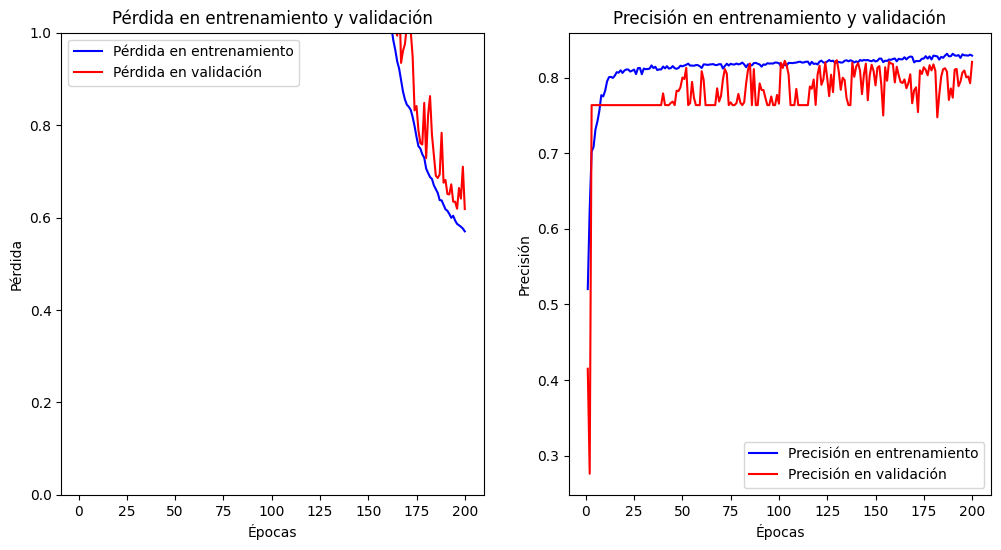

In [ ]:
import matplotlib.pyplot as plt

# Obtener la pérdida en el conjunto de entrenamiento y en el conjunto de validación
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Obtener la precisión en el conjunto de entrenamiento y en el conjunto de validación
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Crear un gráfico
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(12, 6))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Pérdida en entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida en validación')
plt.title('Pérdida en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.ylim(0,1)

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Precisión en entrenamiento')
plt.plot(epochs, val_accuracy, 'r', label='Precisión en validación')
plt.title('Precisión en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()